In [2]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)


In [6]:
import rl_model
importlib.reload(rl_model)

#import fitting

initial_state_expt_file = os.path.join(git_dir, 'data', '189237-expt.json')
final_state_expt_file = os.path.join(git_dir, 'data', '189246-expt.json')

data_file = os.path.join(git_dir, 'data', 'r189245-time-resolved.json')
#ec_cp1 = np.loadtxt(os.path.join(project_dir, 'ec-data', 'Expt6_Summary_CP1.txt'), delimiter=',', skiprows=1).T


with open(data_file) as fd:
    m = json.load(fd)
    timestamps = np.asarray(m['times'])
    _data = m['data']
    print("Number of times: %s" % len(_data))
    

REVERSE = False
  
# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=None, #final_state_expt_file,
                      data=_data, reverse=REVERSE)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()

print(type(env.action_space))

Number of times: 25
<class 'numpy.ndarray'>
0
<class 'gymnasium.spaces.box.Box'>


reward: -3.326158959435721
[-0.27628032  0.30918931  0.46417551]


<IPython.core.display.Javascript object>


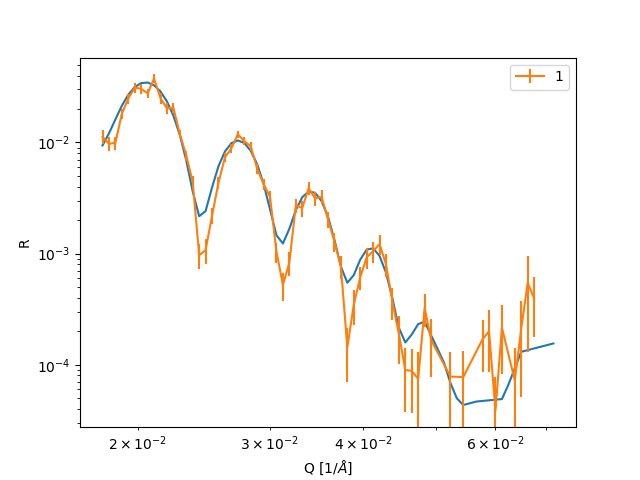

In [7]:
terminated = False

#while not terminated: 
for i in range(1):
    #time.sleep(1)

    # choose a random action
    if False:
        action = env.action_space.sample() 
    else:
        action = env.normalized_parameters

    # take the action and get the information from the environment
    new_state, reward, terminated, truncated, info = env.step(action)
    print("reward: %s" % reward)
    # show the current position and reward
    env.render(action=action, reward=reward) 
    env.plot(errors=True)

In [8]:
%%time

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    #save_path="./logs-forward-no-final-state/",
    save_path="./logs-test/",
    name_prefix="rl_model-forward",
    save_replay_buffer=False,
    save_vecnormalize=True,
)

model = SAC('MlpPolicy', env, use_sde=False, verbose=0)

if True:
    model.learn(2000)
    #model.learn(200000, callback=checkpoint_callback)
    #model.save('UIUC-06-to-01-SAC-forward-no-final-state')
else:
    model = SAC.load("cell-b-CV1-30-SAC")

CPU times: user 12.8 s, sys: 22.5 s, total: 35.3 s
Wall time: 16.3 s


# Compute uncertainties

In [106]:
deltas = env.high_array - env.low_array

samples = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)


samples = np.asarray(samples).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

(3, 25, 100)
(3, 25)


In [107]:
# Evaluate the agent

episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

actions = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    new_obs, reward, terminated, truncated, info = env.step(action)  
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (timestamps[i], obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)

Number of times: 25
Time 0 [0.]: -3.25836 [False] -3.25836
Time 60 [0.04166667]: -3.43927 [False] -6.69762
Time 120 [0.08333334]: -3.13908 [False] -9.8367
Time 180 [0.125]: -2.69555 [False] -12.5323
Time 240 [0.16666667]: -2.21699 [False] -14.7492
Time 300 [0.20833333]: -3.24598 [False] -17.9952
Time 360 [0.25]: -3.1182 [False] -21.1134
Time 420 [0.29166666]: -1.94324 [False] -23.0567
Time 480 [0.33333334]: -2.04583 [False] -25.1025
Time 540 [0.375]: -2.12974 [False] -27.2322
Time 600 [0.41666666]: -1.88827 [False] -29.1205
Time 660 [0.45833334]: -2.1788 [False] -31.2993
Time 720 [0.5]: -2.56927 [False] -33.8686
Time 780 [0.5416667]: -2.71265 [False] -36.5812
Time 840 [0.5833333]: -2.28301 [False] -38.8642
Time 900 [0.625]: -2.72056 [False] -41.5848
Time 960 [0.6666667]: -2.87365 [False] -44.4584
Time 1020 [0.7083333]: -2.61252 [False] -47.071
Time 1080 [0.75]: -3.64165 [False] -50.7126
Time 1140 [0.7916667]: -2.88805 [False] -53.6007
Time 1200 [0.8333333]: -2.80532 [False] -56.406
Tim

['solvent interface', 'PVF thickness', 'PVF rho']


<IPython.core.display.Javascript object>


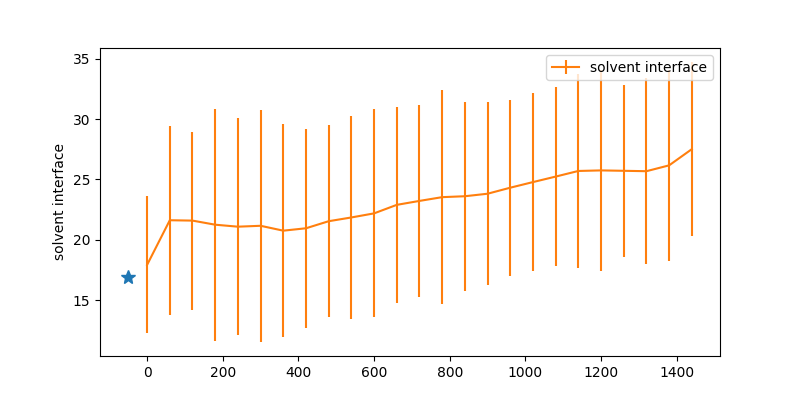

<IPython.core.display.Javascript object>


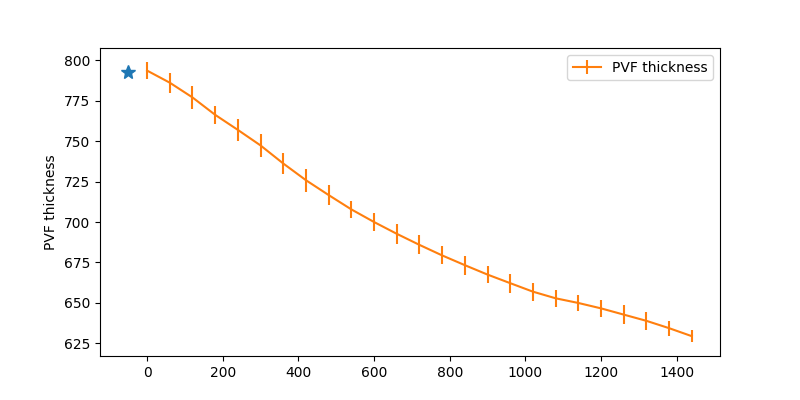

<IPython.core.display.Javascript object>


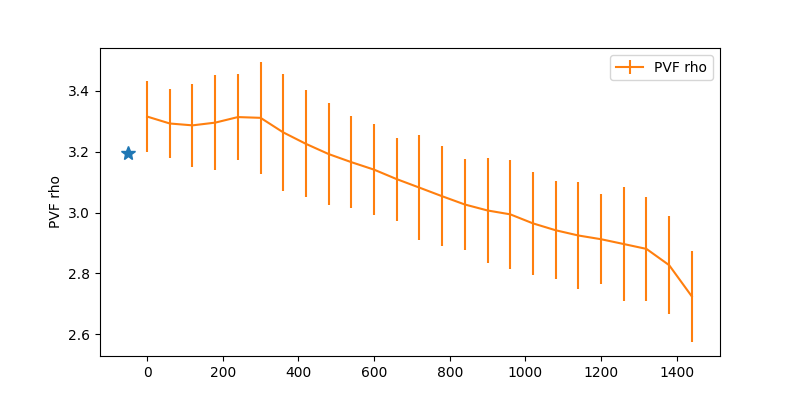

In [108]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T
errors = errs.T

# Bayesian fit trend
#with open( '/Users/m2d/git/vae-sld/data/time-resolved/cell_b/trend-201289.json') as fd:
#    bayes_fits = json.load(fd)

if REVERSE:
    t_initial = timestamps[-1]+50
    t_final = -50
    _times = np.flip(timestamps)
else:
    t_final = timestamps[-1]+50
    t_initial = -50
    _times = timestamps

n_times = len(env.data)

print(env.par_labels)
for i in range(pars.shape[0]):
    fig = plt.subplots(dpi=100, figsize=(8, 4))
    #plt.plot(times, pars[i], label=env.par_labels[i])
    plt.plot([t_initial,], [env.parameters[i]], linestyle='', marker='*', markersize=10)
    #plt.plot([t_final,], [env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    plt.errorbar(_times, pars[i], yerr=errs[i], label=env.par_labels[i])
    
    #plt.errorbar(bayes_fits[0], bayes_fits[1][env.par_labels[i]], yerr=bayes_fits[2][env.par_labels[i]], label='Bayesian fit')
    plt.ylabel(env.par_labels[i])
    plt.legend()

Number of times: 25


<IPython.core.display.Javascript object>


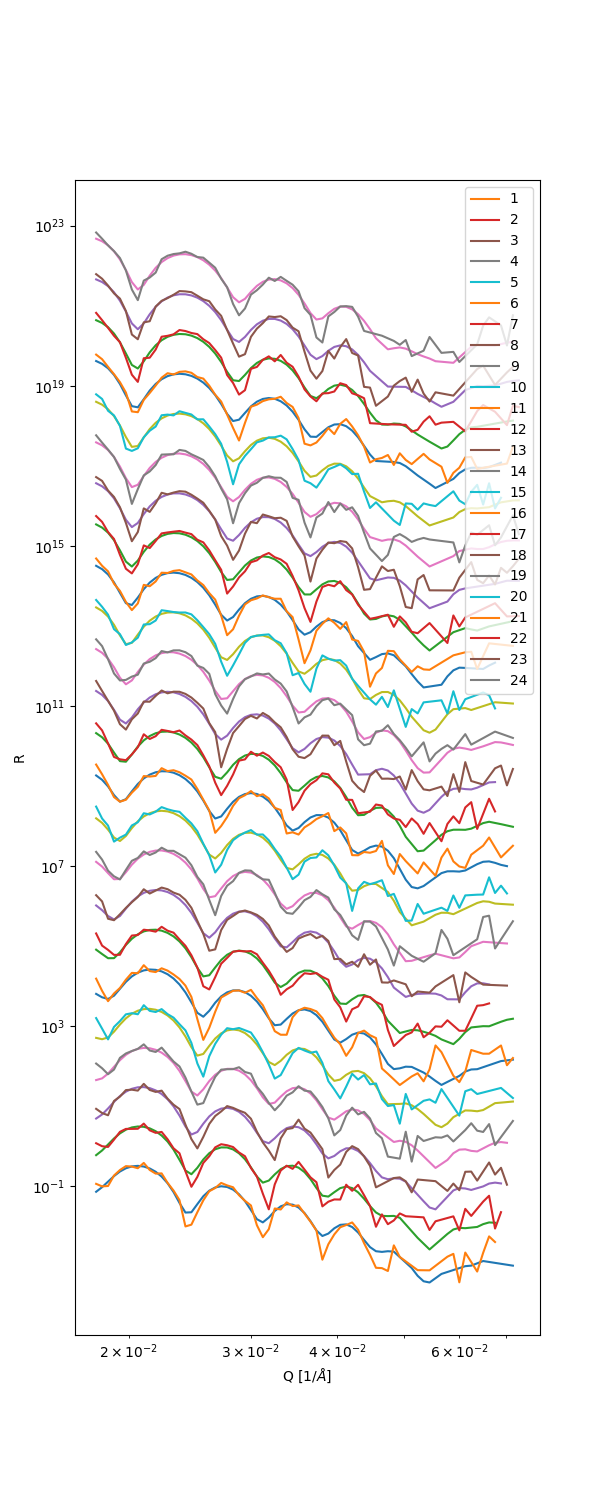

In [109]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig = plt.subplots(dpi=100, figsize=(6, 15))
for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = env.step(action)

    env.plot(scale=10.**i, newfig=False)
